In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import geopandas as gpd
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import sys
from tqdm import tqdm

from shapely.geometry import LineString

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'
LOG_DIR = '../../../log'

In [4]:
# Custom imports
sys.path.append(LIB_DIR)
from gtfs_sequence import Sequence

In [5]:
def peek(df):
    print(len(df))
    display(df.iloc[:3])

In [6]:
route_gdf = gpd.read_file(f'{DATA_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp')
route_gdf = route_gdf.to_crs(CRS_LATLON)

<AxesSubplot:>

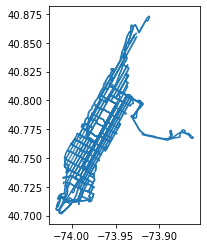

In [7]:
route_gdf.plot()

In [8]:
# Extract out routes represented as MultiLineString geometries.
ls_gdf = route_gdf[route_gdf['geometry'].geom_type == 'LineString']
mls_gdf = route_gdf[route_gdf['geometry'].geom_type == 'MultiLineString']
peek(ls_gdf)
peek(mls_gdf)

55


,route_id,route_dir,route_shor,route_long,color,geometry
6,M104,M104_0,M104,West Harlem - Times Square,#B933AD,"LINESTRING (-73.99014 40.75652, -73.99027 40.7..."
7,M104,M104_1,M104,West Harlem - Times Square,#B933AD,"LINESTRING (-73.95309 40.81422, -73.95311 40.8..."
8,M106,M106_0,M106,East Harlem - West Side,#6CBE45,"LINESTRING (-73.97265 40.79499, -73.97264 40.7..."


27


,route_id,route_dir,route_shor,route_long,color,geometry
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.95142 40.78518, -73.9518..."
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."


,route_id,route_dir,route_shor,route_long,color,geometry
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."


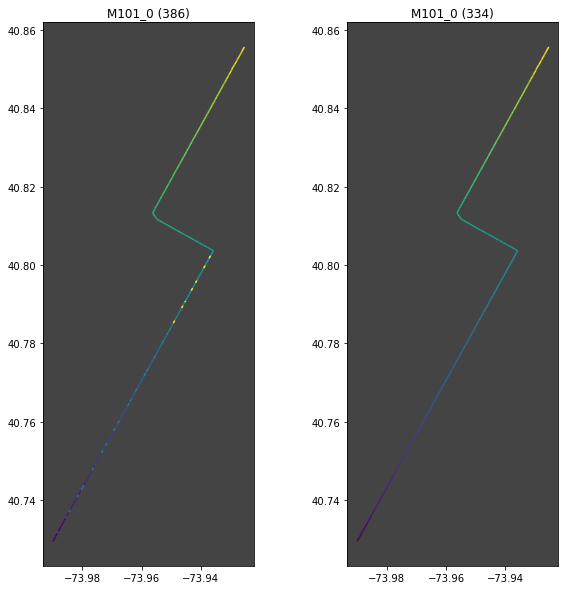

,route_id,route_dir,route_shor,route_long,color,geometry
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.95142 40.78518, -73.9518..."


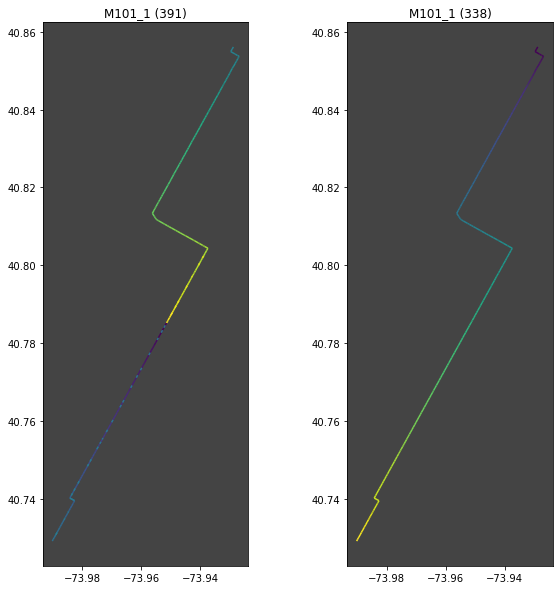

,route_id,route_dir,route_shor,route_long,color,geometry
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."


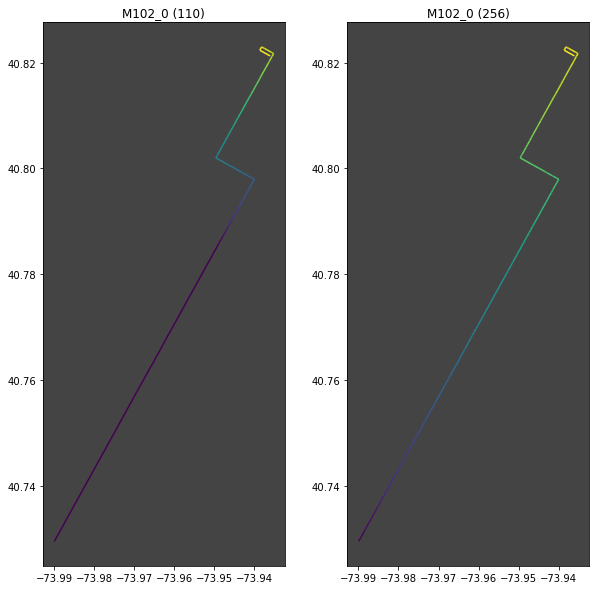

,route_id,route_dir,route_shor,route_long,color,geometry
3,M102,M102_1,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.93594 40.82119, -73.9358..."


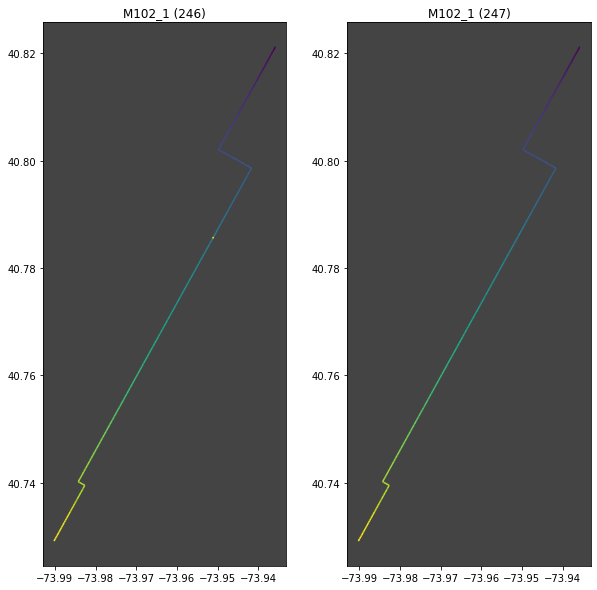

,route_id,route_dir,route_shor,route_long,color,geometry
4,M103,M103_0,M103,East Harlem - City Hall,#B933AD,"MULTILINESTRING ((-74.00619 40.71193, -74.0061..."


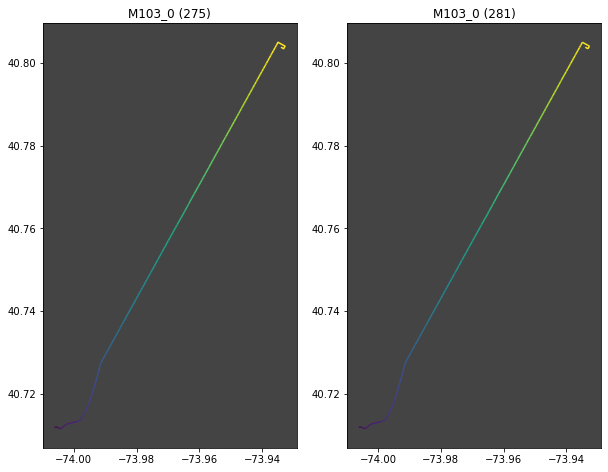

,route_id,route_dir,route_shor,route_long,color,geometry
5,M103,M103_1,M103,East Harlem - City Hall,#B933AD,"MULTILINESTRING ((-73.93779 40.80386, -73.9379..."


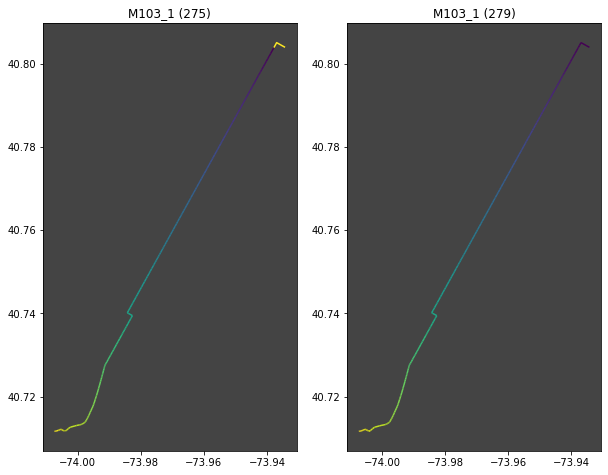

,route_id,route_dir,route_shor,route_long,color,geometry
14,M11,M11_0,M11,Riverbank Park & Harlem - West Village,#FAA61A,"MULTILINESTRING ((-74.00635 40.73694, -74.0064..."


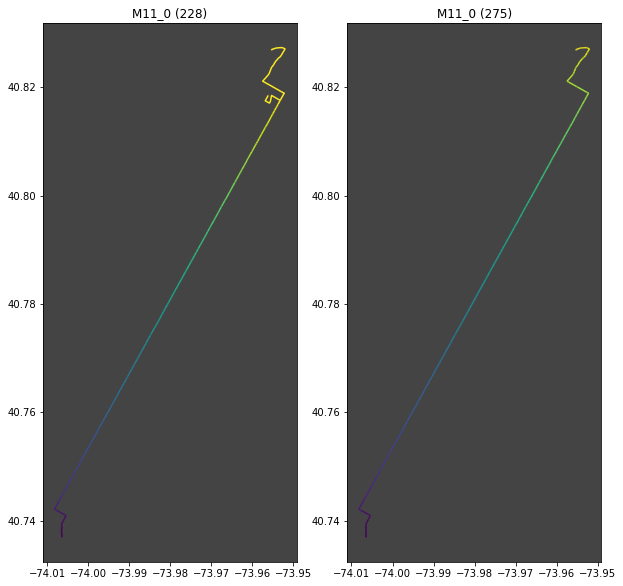

,route_id,route_dir,route_shor,route_long,color,geometry
15,M11,M11_1,M11,Riverbank Park & Harlem - West Village,#FAA61A,"MULTILINESTRING ((-73.95607 40.81855, -73.9559..."


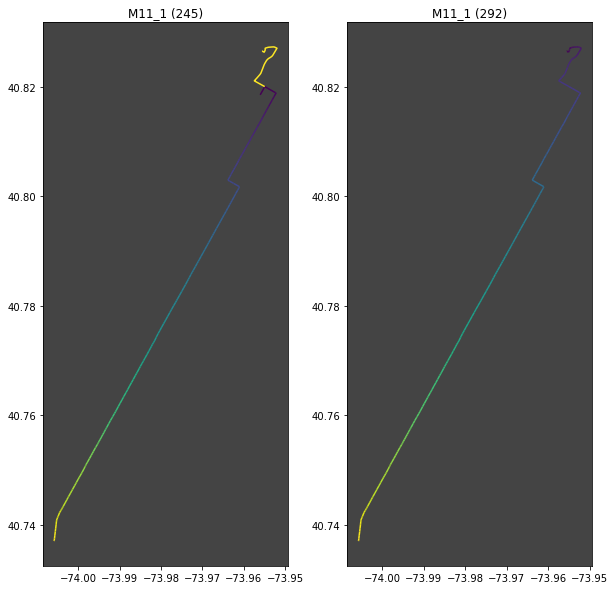

,route_id,route_dir,route_shor,route_long,color,geometry
18,M14A+,M14A+_0,M14A-SBS,Lower East Side - Abingdon Sq,#6CBE45,"MULTILINESTRING ((-74.00498 40.73741, -74.0048..."


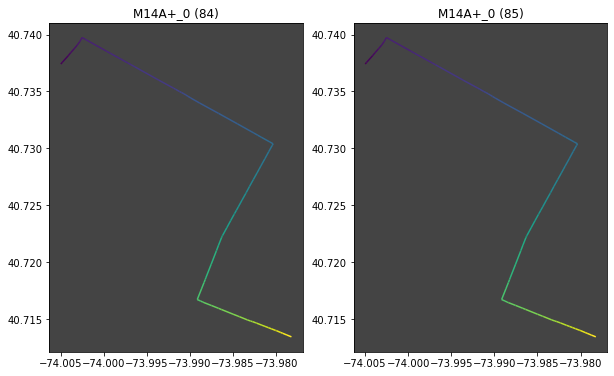

,route_id,route_dir,route_shor,route_long,color,geometry
19,M14A+,M14A+_1,M14A-SBS,Lower East Side - Abingdon Sq,#6CBE45,"MULTILINESTRING ((-73.97794 40.71334, -73.9779..."


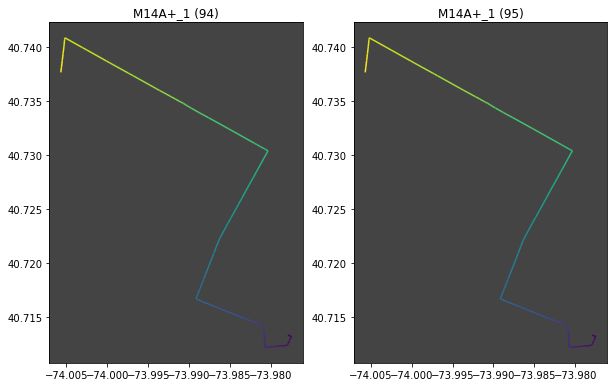

,route_id,route_dir,route_shor,route_long,color,geometry
24,M15,M15_0,M15,East Harlem - South Ferry,#006CB7,"MULTILINESTRING ((-74.01246 40.70148, -74.0125..."


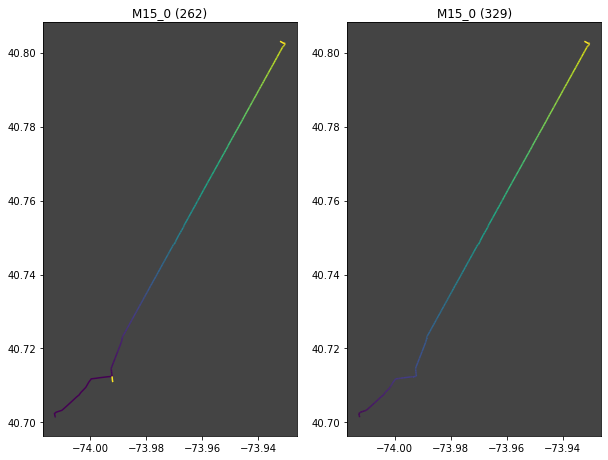

,route_id,route_dir,route_shor,route_long,color,geometry
25,M15,M15_1,M15,East Harlem - South Ferry,#006CB7,"MULTILINESTRING ((-73.93249 40.80318, -73.9326..."


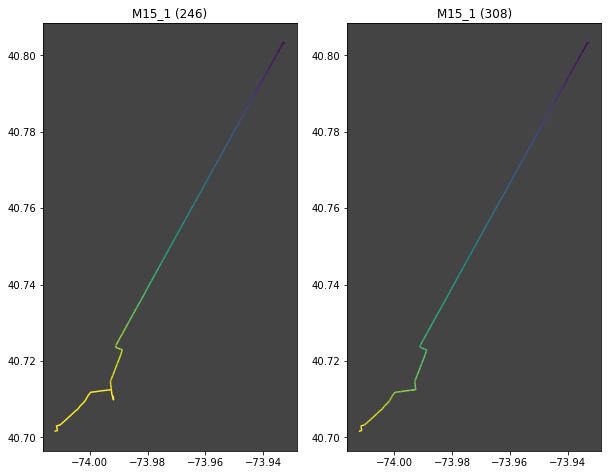

,route_id,route_dir,route_shor,route_long,color,geometry
34,M22,M22_0,M22,Lower East Side - Battery Park City,#00AEEF,"MULTILINESTRING ((-74.01576 40.71454, -74.0162..."


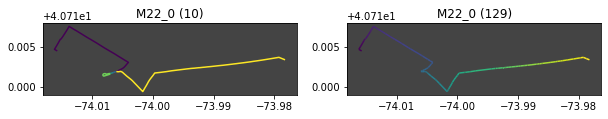

,route_id,route_dir,route_shor,route_long,color,geometry
38,M2,M2_0,M2,Washington Heights - East Village,#B933AD,"MULTILINESTRING ((-73.99037 40.73135, -73.9902..."


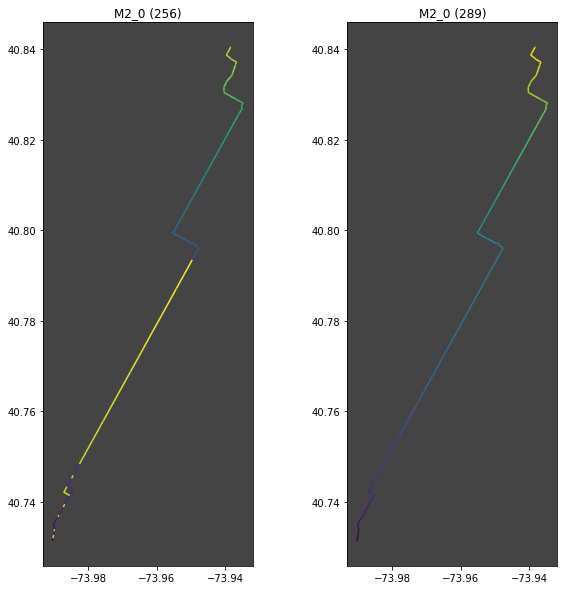

,route_id,route_dir,route_shor,route_long,color,geometry
39,M2,M2_1,M2,Washington Heights - East Village,#B933AD,"MULTILINESTRING ((-73.93859 40.84058, -73.9394..."


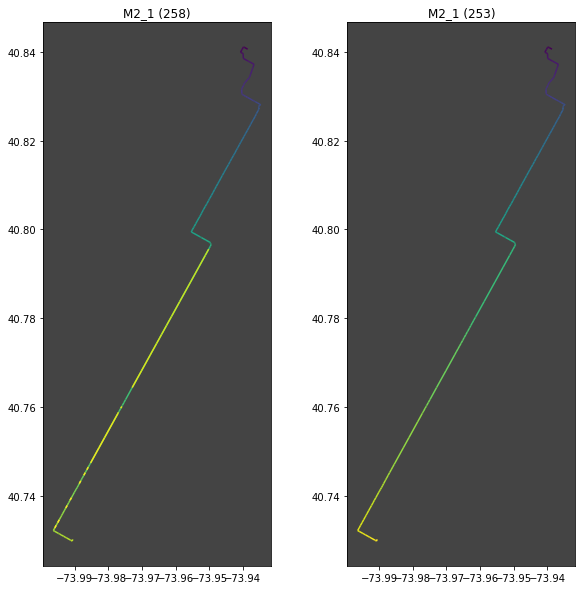

,route_id,route_dir,route_shor,route_long,color,geometry
40,M31,M31_0,M31,Yorkville - Clinton,#B933AD,"MULTILINESTRING ((-73.99183 40.76796, -73.9910..."


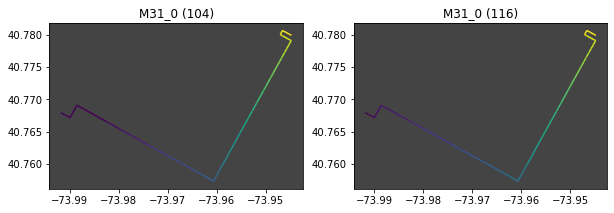

,route_id,route_dir,route_shor,route_long,color,geometry
42,M34+,M34+_0,M34-SBS,East Side - Javits Center,#006CB7,"MULTILINESTRING ((-74.00390 40.75659, -74.0033..."


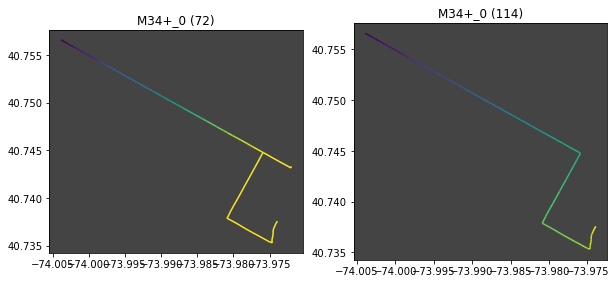

,route_id,route_dir,route_shor,route_long,color,geometry
43,M34+,M34+_1,M34-SBS,East Side - Javits Center,#006CB7,"MULTILINESTRING ((-73.97351 40.73808, -73.9734..."


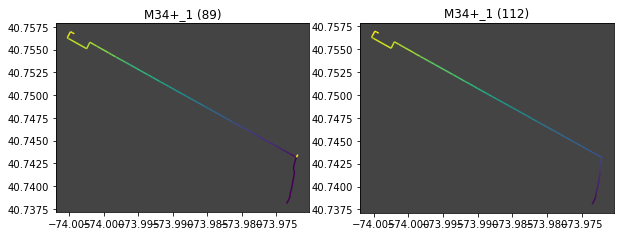

,route_id,route_dir,route_shor,route_long,color,geometry
48,M3,M3_0,M3,Fort George - East Village,#B933AD,"MULTILINESTRING ((-73.95258 40.81076, -73.9521..."


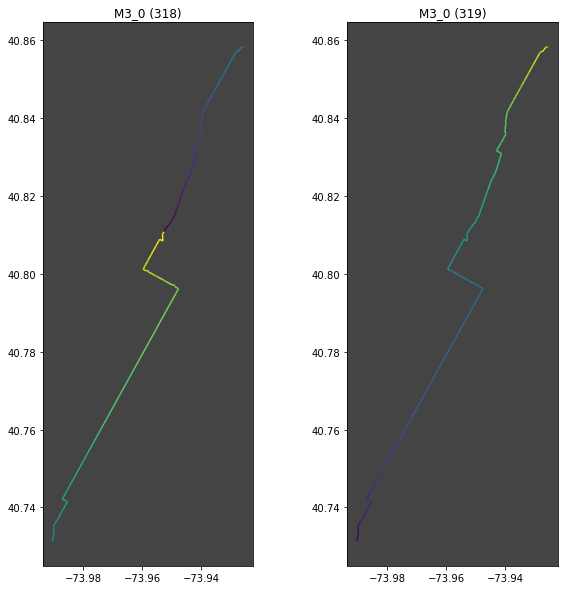

,route_id,route_dir,route_shor,route_long,color,geometry
49,M3,M3_1,M3,Fort George - East Village,#B933AD,"MULTILINESTRING ((-73.92546 40.85817, -73.9256..."


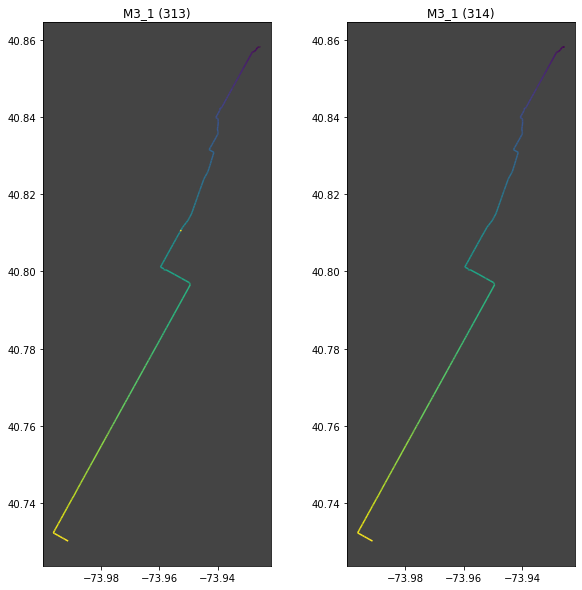

,route_id,route_dir,route_shor,route_long,color,geometry
52,M4,M4_0,M4,The Cloisters - 32 St,#00AEEF,"MULTILINESTRING ((-73.98410 40.74656, -73.9825..."


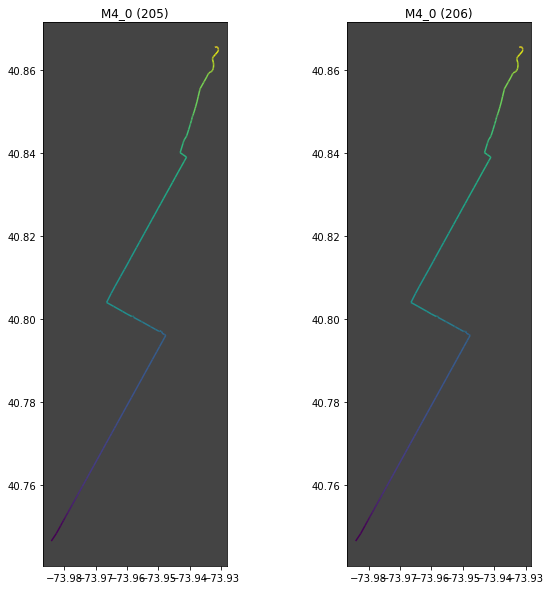

,route_id,route_dir,route_shor,route_long,color,geometry
53,M4,M4_1,M4,The Cloisters - 32 St,#00AEEF,"MULTILINESTRING ((-73.95643 40.81841, -73.9581..."


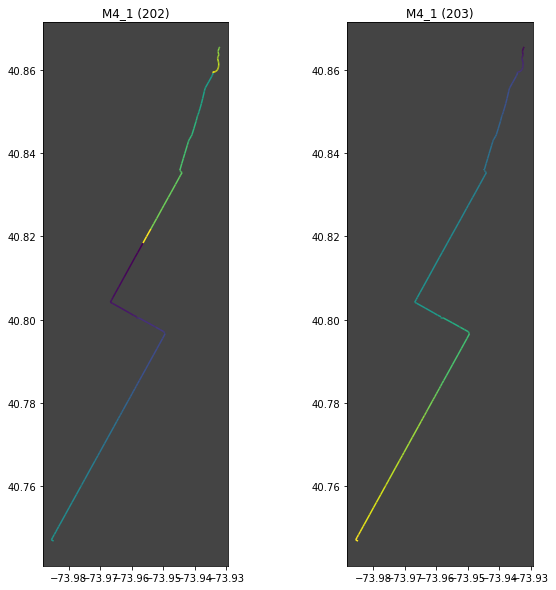

,route_id,route_dir,route_shor,route_long,color,geometry
60,M5,M5_0,M5,George Washington Bridge - 31 St & 6 Av,#EE352E,"MULTILINESTRING ((-73.95409 40.82127, -73.9529..."


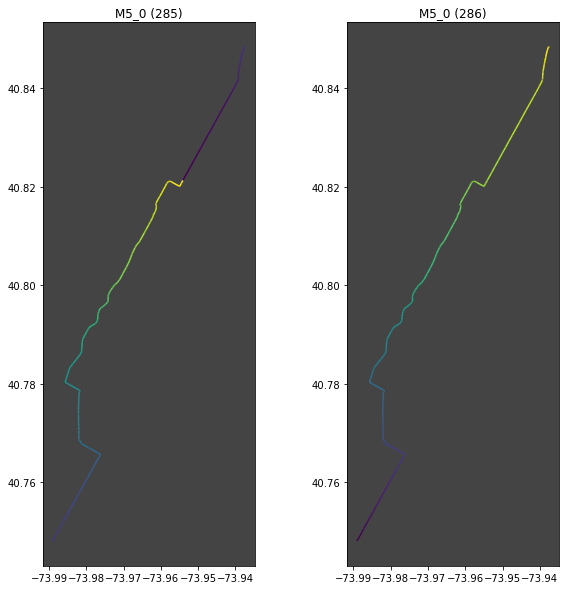

,route_id,route_dir,route_shor,route_long,color,geometry
61,M5,M5_1,M5,George Washington Bridge - 31 St & 6 Av,#EE352E,"MULTILINESTRING ((-73.93765 40.84840, -73.9376..."


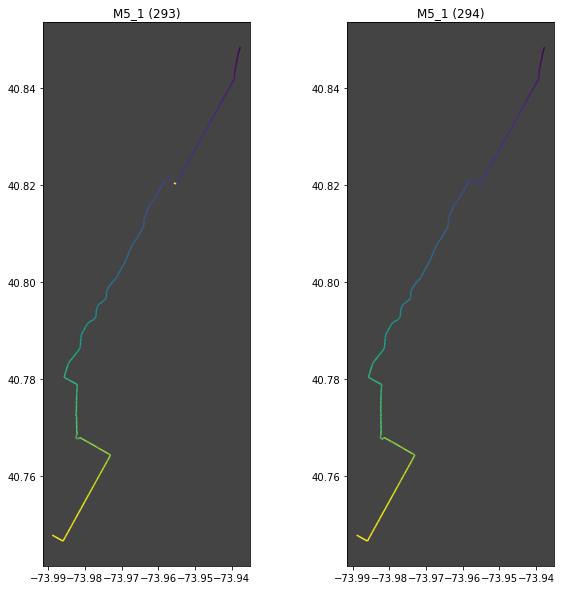

,route_id,route_dir,route_shor,route_long,color,geometry
62,M60+,M60+_0,M60-SBS,LaGuardia Airport - West Side,#EE352E,"MULTILINESTRING ((-73.96772 40.80182, -73.9676..."


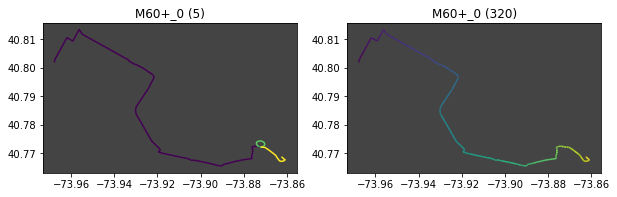

,route_id,route_dir,route_shor,route_long,color,geometry
63,M60+,M60+_1,M60-SBS,LaGuardia Airport - West Side,#EE352E,"MULTILINESTRING ((-73.86264 40.76879, -73.8627..."


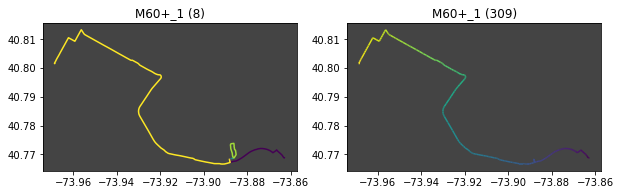

,route_id,route_dir,route_shor,route_long,color,geometry
74,M8,M8_0,M8,West Village - East Village LTD,#00AEEF,"MULTILINESTRING ((-74.01019 40.73285, -74.0101..."


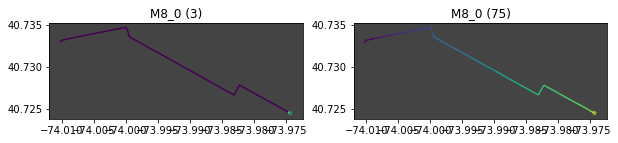

In [69]:
def plot_multi_line_string(gdf):
    display(gdf)
    mls_geometry = gdf['geometry'].iloc[0]
    line_strings = []
    orders = []
    starts = []
    ends = []
    
    new_coords = []
    start_line_string_map = {}
    end_line_string_map = {}
    
    for i, line_string in enumerate(mls_geometry):
        start = line_string.coords[0]
        end = line_string.coords[-1]
        
        start_line_string_map[start] = line_string
        end_line_string_map[end] = line_string
        
        line_strings.append(line_string)
        orders.append(i)
        starts.append(start)
        ends.append(end)
        
    # Pick coordinate in middle of route to connect other coordinates to.
    start_coord = mls_geometry[int(len(mls_geometry) / 2)].coords[0]
    new_coords.append(start_coord)
    
    # Grow the fixed route by iteratively attaching LineStrings which start from
    # the current coordinate and setting the current coordinate to the end
    # coordinate of the LineString most recently attached.
    start_coord = new_coords[-1]
    while start_coord in start_line_string_map:
        matching_line_string = start_line_string_map[start_coord]
        end_coord = matching_line_string.coords[-1]
        
        # Attach all new coordinates from matching LineString.
        for coord in matching_line_string.coords[1:]:
            new_coords.append(coord)
        
        del start_line_string_map[start_coord]
        if end_coord in end_line_string_map:
            del end_line_string_map[end_coord]
        
        # Set grow coordinate to end coordinate of LineString attached.
        start_coord = end_coord
        
    # Grow the fixed route in the other direction.
    end_coord = new_coords[0]
    while end_coord in end_line_string_map:
        matching_line_string = end_line_string_map[end_coord]
        start_coord = matching_line_string.coords[0]
        
        # Insert coordinates from matching LineString in reverse order.
        for coord in matching_line_string.coords[::-1][1:]:
            new_coords.insert(0, coord)
        
        del end_line_string_map[end_coord]
        if start_coord in start_line_string_map:
            del start_line_string_map[start_coord]
        
        end_coord = start_coord
        
    def add_starting_line_string(line_string, new_coords):
        end_coord = line_string.coords[-1]
        insertion_index = new_coords.index(end_coord)
        return list(line_string.coords) + new_coords[insertion_index + 1:]
    
    def add_ending_line_string(line_string, new_coords):
        start_coord = line_string.coords[0]
        insertion_index = new_coords.index(start_coord)
        return new_coords[:insertion_index] + list(line_string.coords)
            
        
    try_insertion = True
    while len(start_line_string_map) > 0 and try_insertion:
        try_insertion = False
        remove_keys = []
        for start_coord, start_line_string in start_line_string_map.items():
            end_coord = start_line_string.coords[-1]
            if end_coord in new_coords:
                appended_coords = add_starting_line_string(start_line_string, new_coords)
                remove_keys.append(start_coord)
                try_insertion = True
                if len(appended_coords) > len(new_coords):
                    new_coords = appended_coords
        for remove_key in remove_keys:
            del start_line_string_map[remove_key]
            
    try_insertion = True
    while len(end_line_string_map) > 0 and try_insertion:
        try_insertion = False
        remove_keys = []
        for end_coord, end_line_string in end_line_string_map.items():
            start_coord = end_line_string.coords[0]
            if start_coord in new_coords:
                appended_coords = add_ending_line_string(end_line_string, new_coords)
                remove_keys.append(end_coord)
                try_insertion = True
                if len(appended_coords) > len(new_coords):
                    new_coords = appended_coords
        for remove_key in remove_keys:
            del end_line_string_map[remove_key]
    
    new_line_strings = []
    new_orders = []
    for i in range(len(new_coords) - 1):
        new_line_string = LineString((
            new_coords[i],
            new_coords[i + 1],
        ))
        new_line_strings.append(new_line_string)
        new_orders.append(i)
        
    ls_gdf = gpd.GeoDataFrame({
        'order': orders,
        'start': starts,
        'end': ends,
    }, geometry=line_strings, crs=CRS_LATLON)
    
    nls_gdf = gpd.GeoDataFrame({
        'order': new_orders,
    }, geometry=new_line_strings, crs=CRS_LATLON)
    
    #print(ls_gdf.iloc[-1]['geometry'])
    #print(new_line_strings[0])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ls_gdf.plot(ax=ax[0], column='order')
    nls_gdf.plot(ax=ax[1], column='order')
    ax[0].set_facecolor('#444')
    ax[1].set_facecolor('#444')
    ax[0].set_title(f"{gdf.iloc[0]['route_dir']} ({len(mls_geometry)})")
    ax[1].set_title(f"{gdf.iloc[0]['route_dir']} ({len(new_coords)})")
    plt.show()
    
for i in range(len(mls_gdf)):
    plot_multi_line_string(mls_gdf.iloc[i:i + 1])
    
#plot_multi_line_string(mls_gdf[mls_gdf['route_dir'] == 'M15_1'])